# Oppgave a)

In [1]:
cd ..

c:\Users\leand\FYS-STK\FYS-STK3155-project-2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# import functions from src folder
import src.regression_tools as rt
import src.regression_cost_funcs as rcf
import src.gradient_descent as gd
import src.data_generation as dg

In [20]:
#generate data
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.01, seed=0)

poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)

## Analysis MSE developmens over epochs for different learning-rate 

In [109]:
# We want to models of gradient decent, high and low learning-rate
lr1 = 0.1
lr2 = 0.01

#choose cost function model to investigate:
model = rcf.OLSCost()

descent1 = gd.GradientDescent(mode="normal", momentum_param=0, batch_size=None, store_extra=True)
descent2 = gd.GradientDescent(mode="normal", momentum_param=0, batch_size=None, store_extra=True)

#choose initial weigths and number of epochs
w_init = np.zeros(len(X[0]))
epochs = 2000

#train on the train data and return final weights
w1 = descent1.train(X_train, w_init, z_train, model, learning_rate=lr1, n_epochs = epochs)
w2 = descent2.train(X_train, w_init, z_train, model, learning_rate=lr2, n_epochs = epochs)

#extract weights as a function of epocs
wlog1 = descent1.weights 
wlog2 = descent2.weights 

In [110]:
# Maby make it as a function:

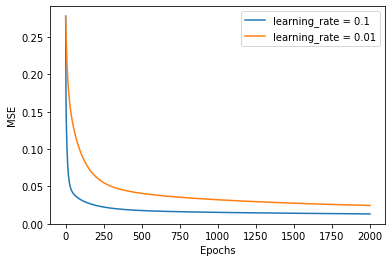

In [111]:
epoc_arr = np.linspace(0, epochs, epochs+1)

# y_pred as an array corrosponding to predictiv y for each epoch 
z_pred_test1 = (X_test@wlog1.T).T
z_pred_train1 = (X_train@wlog1.T).T
MSE_test1 = rt.MSE_vec(z_test, z_pred_test1)
MSE_train1 = rt.MSE_vec(z_train, z_pred_train1)

# 
z_pred_test2 = (X_test@wlog2.T).T
z_pred_train2 = (X_train@wlog2.T).T
MSE_test2= rt.MSE_vec(z_test, z_pred_test2)
MSE_train2 = rt.MSE_vec(z_train, z_pred_train2)

plt.plot(epoc_arr, MSE_test1, label=f"learning_rate = {lr1}")
plt.plot(epoc_arr, MSE_test2, label=f"learning_rate = {lr2}")
# plt.plot(epoc_arr, MSE_train1, label=f"learning_rate_train = {lr1}")
# plt.plot(epoc_arr, MSE_train2, label=f"learning_rate_train = {lr2}")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()


## Analysis MSE over learning rate - Fixed n_epochs

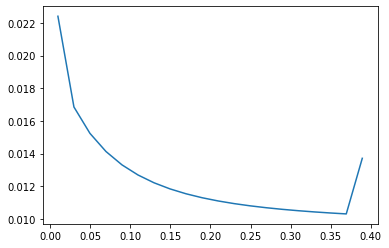

In [130]:

def lr_iter(X, z, lr_range, seed=0):
    """ """
    # Split data:
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25, random_state=seed)

    MSE_array = np.zeros(len(lr_range))
    for i, lr in enumerate(lr_range):
        w_init = np.zeros(len(X_train[0]))
        epochs = 3000
        descent = gd.GradientDescent(mode="normal", momentum_param=0, batch_size=None, store_extra=False)
        w = descent.train(X_train, w_init, z_train, model, learning_rate=lr, n_epochs = epochs)
        z_pred_test = (X_test @ w)
        MSE_array[i] = rt.MSE(z_test, z_pred_test.flatten())
    return MSE_array


# create linspace learning-rate
learning_rate_range = np.linspace(0.01, 0.3893, 20)
MSE_arr = lr_iter(X_train, z_train, learning_rate_range)
plt.plot(learning_rate_range, MSE_arr)
plt.show()

# CHOICE: Choose learning-rate to be 0.3 for the rest of the exercise


## Analyze MSE development over epochs for different batch-sizes

In [162]:
# We want two models of gradient decent; None, large and small batch sizes
b1 = None
b2 = 512
b3 = 128

#choose cost function model to investigate:
model = rcf.OLSCost()

descent1 = gd.GradientDescent(mode="normal", momentum_param=0, batch_size=b1, store_extra=True)
descent2 = gd.GradientDescent(mode="normal", momentum_param=0, batch_size=b2, store_extra=True)
descent3 = gd.GradientDescent(mode="normal", momentum_param=0, batch_size=b3, store_extra=True)


#choose initial weigths and number of epochs
w_init = np.zeros(len(X[0]))
epochs = 250

#train on the train data and return final weights
w1 = descent1.train(X_train, w_init, z_train, model, learning_rate=0.3, n_epochs = epochs)
w2 = descent2.train(X_train, w_init, z_train, model, learning_rate=0.3, n_epochs = epochs)
w3 = descent3.train(X_train, w_init, z_train, model, learning_rate=0.3, n_epochs = epochs)


#extract weights as a function of epocs
wlog1 = descent1.weights 
wlog2 = descent2.weights 
wlog3 = descent3.weights

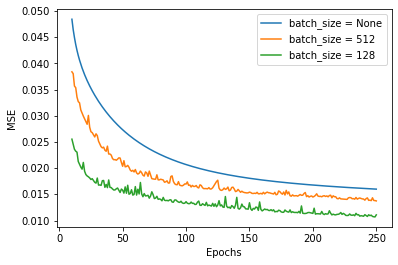

In [163]:
epoc_arr = np.linspace(0, epochs, epochs+1)

# y_pred as an array corrosponding to predictiv y for each epoch 
z_pred_test1 = (X_test@wlog1.T).T
z_pred_train1 = (X_train@wlog1.T).T
MSE_test1 = rt.MSE_vec(z_test, z_pred_test1)
MSE_train1 = rt.MSE_vec(z_train, z_pred_train1)

# 
z_pred_test2 = (X_test@wlog2.T).T
z_pred_train2 = (X_train@wlog2.T).T
MSE_test2= rt.MSE_vec(z_test, z_pred_test2)
MSE_train2 = rt.MSE_vec(z_train, z_pred_train2)

# 
z_pred_test3 = (X_test@wlog3.T).T
z_pred_train3 = (X_train@wlog3.T).T
MSE_test3 = rt.MSE_vec(z_test, z_pred_test3)
MSE_train3 = rt.MSE_vec(z_train, z_pred_train3)

plt.plot(epoc_arr[10:], MSE_test1[10:], label=f"batch_size = {b1}")
plt.plot(epoc_arr[10:], MSE_test2[10:], label=f"batch_size = {b2}")
plt.plot(epoc_arr[10:], MSE_test3[10:], label=f"batch_size = {b3}")
# plt.plot(epoc_arr, MSE_train1, label=f"learning_rate_train = {lr1}")
# plt.plot(epoc_arr, MSE_train2, label=f"learning_rate_train = {lr2}")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()




## Analysis MSE over batch size - Fixed epochs

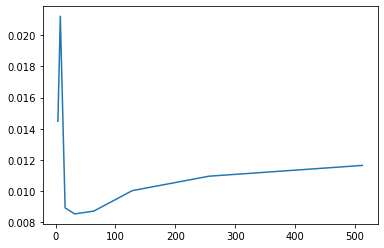

In [159]:
def batch_iter(X, z, b_range, seed=1):
    """ """
    np.random.seed(seed)
    # Split data:
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25, random_state=seed)

    MSE_array = np.zeros(len(b_range))
    for i, b in enumerate(b_range):
        w_init = np.zeros(len(X_train[0]))
        epochs = 250
        descent = gd.GradientDescent(mode="normal", momentum_param=0, batch_size=b, store_extra=False)
        w = descent.train(X_train, w_init, z_train, model, learning_rate=0.3, n_epochs = epochs)
        z_pred_test = (X_test @ w)
        MSE_array[i] = rt.MSE(z_test, z_pred_test.flatten())
    return MSE_array


# create linspace learning-rate
batch_range = np.array([4, 8, 16, 32, 64, 128, 256, 512])
#batch_range = np.linspace(10, 510, 500, dtype=int)
MSE_arr = batch_iter(X_train, z_train, batch_range)
plt.plot(batch_range, MSE_arr)
plt.show()

# CHOICE: Choose batch size to be 128 for the rest of the exercise
